# Juan David Galan Vargas: 202111470

# Practica 4: Fotometria de Apertura

In [1]:
from glob import glob
from astropy.io import fits
from astropy.visualization import hist
from astropy.modeling import fitting
from astropy.modeling.models import custom_model
fitter = fitting.LevMarLSQFitter()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import scipy.ndimage as ndi
import astropy.stats as astrostats

# configuration
np.set_printoptions(linewidth=120) # para que se vea

cmap = plt.get_cmap("inferno")
cmap.set_bad(color="r")
cmap.set_over(color="w")
if "astro" in plt.colormaps():
    colormaps.unregister("astro")
colormaps.register(cmap,name="astro")
plt.rcParams["image.origin"] = "lower"
plt.rcParams["image.cmap"] = "astro"
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["axes.labelsize"] = 15



def quantile_linspace(arr,num=100,lower=0.01,upper=0.99):
    return np.linspace(*np.quantile(np.ravel(arr),[lower,upper]),num=num)

def quantile_imshow(img,lower=0.01,upper=0.99,**kwargs):
    img_vmin = np.quantile(img,lower)
    img_vmax = np.quantile(img,upper)
    return plt.imshow(img,vmin=img_vmin,vmax=img_vmax,**kwargs)

def quantile_hist(data,num=100,lower=0.01,upper=0.99):
    return plt.hist(np.ravel(data),bins=quantile_linspace(np.ravel(data),num,lower,upper))

def pseudomode(arr,sigma=1.6,maxiters=20):
    masked = astrostats.sigma_clip(arr,sigma=sigma,maxiters=maxiters)
    return arr[~masked.mask].mean()

In [2]:
glob("*")

['aperture_photometry_1.ipynb',
 'datos',
 'Fotometria General.ipynb',
 'Fotometria.ipynb',
 'Imagenes Reducidos']

In [3]:
dat = glob("Imagenes Reducidos/*.FITS")
dat

['Imagenes Reducidos\\M92 Blue 1 Reducido por Bias y Flat.fits',
 'Imagenes Reducidos\\M92 Blue2 Reducido por Bias y Flat.fits',
 'Imagenes Reducidos\\M92 Visual 1 Reducido por Bias y Flat.fits',
 'Imagenes Reducidos\\M92 Visual 2 Reducido por Bias y Flat.fits']

In [4]:
titles = {
    0: "Blue1",
    1: "Blue2",
    2: "Visual1",
    3: "Visual2"}

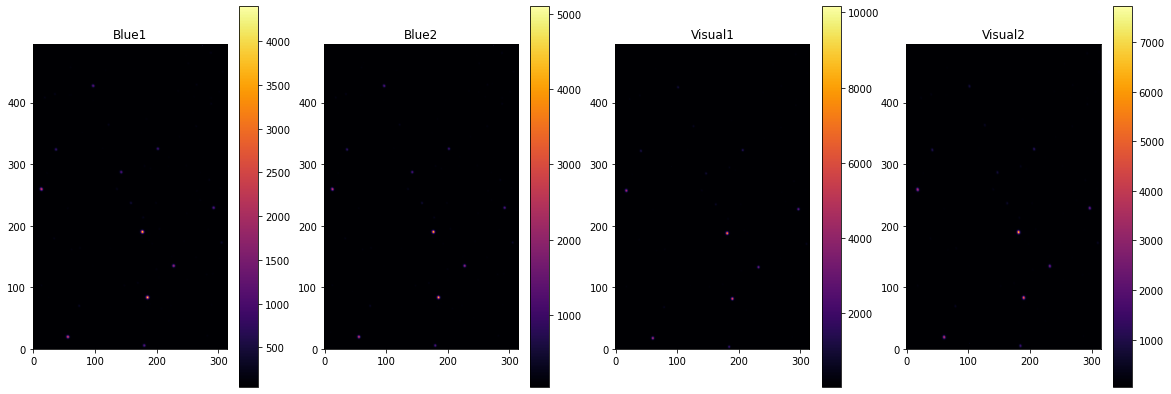

In [5]:
images = [fits.getdata(f) for f in dat]
fig,ax = plt.subplots(ncols=4,figsize=(20,7))
for i in range(4):
    plt.sca(ax[i])
    plt.imshow(images[i],vmin=50)
    plt.title(titles[i])
    plt.colorbar()

In [6]:
headers = [fits.getheader(f) for f in dat]

In [7]:
headers

[SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                  -64 / array data type                                
 NAXIS   =                    2 / number of array dimensions                     
 NAXIS1  =                  315                                                  
 NAXIS2  =                  496                                                  
 OBJECT  = 'M-92 B  '            /                                               
 ORIGIN  = 'KPNO-IRAF'           /                                               
 DATE    = '17-09-93'            /                                               
 IRAFNAME= 'm92014.imh'          /  NAME OF IRAF IMAGE FILE                      
 IRAF-MAX=           4.942000E3  /  DATA MAX                                     
 IRAF-MIN=           4.800000E2  /  DATA MIN                                     
 IRAF-BPX=                   16  /  DATA BITS/PIXEL                              
 IRAFTYPE= 'SHOR

In [8]:
from skimage.feature import peak_local_max
from photutils.centroids import centroid_sources, centroid_quadratic

In [9]:
from photutils.aperture import CircularAperture, ApertureStats
from photutils.profiles import RadialProfile
from astropy.modeling.models import Gaussian1D,Voigt1D,Const1D
from astropy.modeling.fitting import LevMarLSQFitter
fitter = LevMarLSQFitter(calc_uncertainties=True)

In [10]:
from sklearn.neighbors import NearestNeighbors

In [11]:
from photutils.aperture import CircularAnnulus

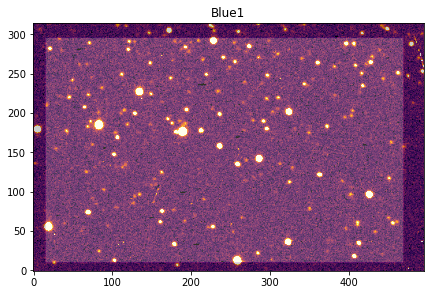

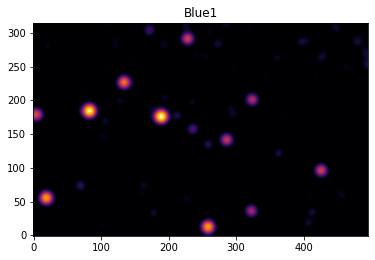

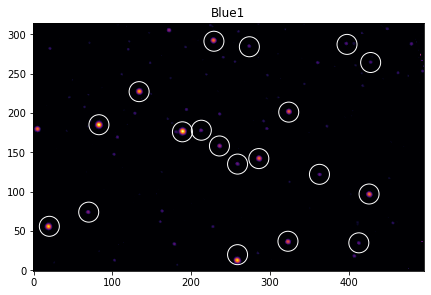

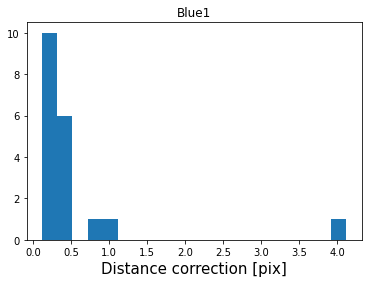

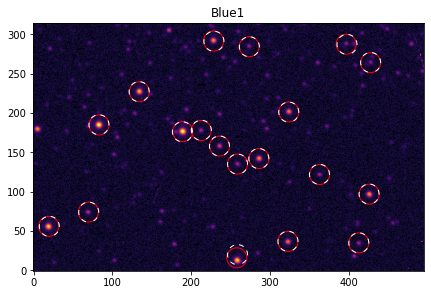

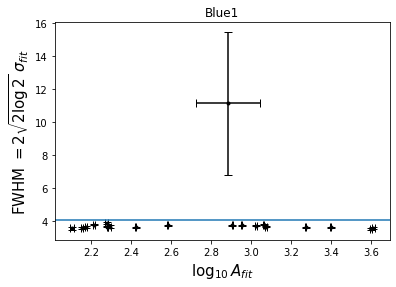

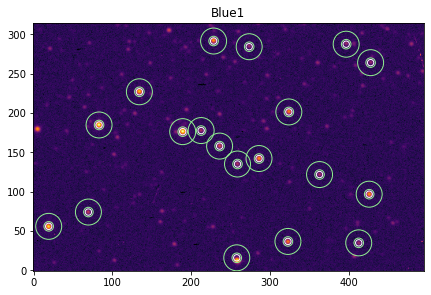

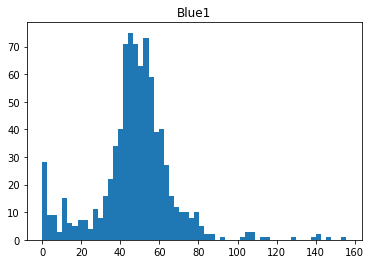

[-2.11425259 -2.05087976 -1.57331222 -1.26442013 -0.80541022 -0.78266028 -0.68748087 -1.21225766 -0.51806769
 -0.39759656  0.42230598  0.86278333  1.10983848  1.15026815  1.19698672  1.48774691  1.56451919  1.32311541
  1.45449162]


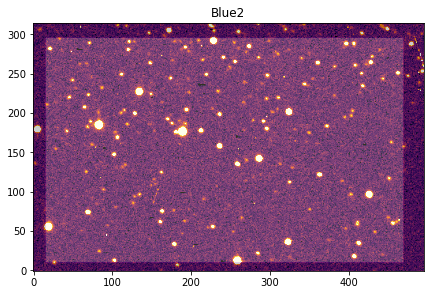

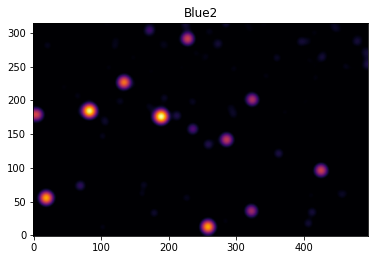

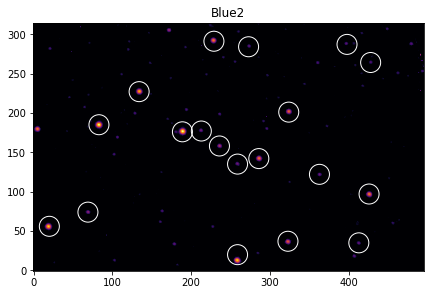

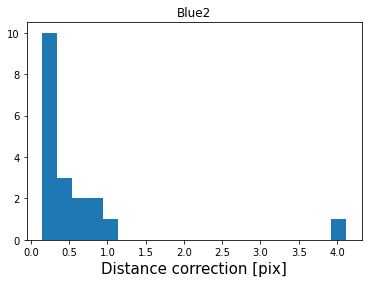

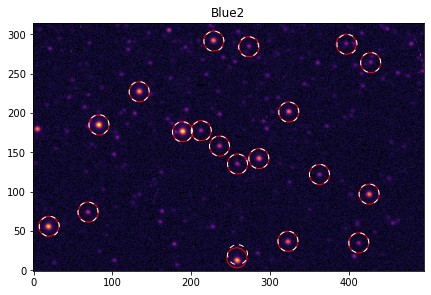

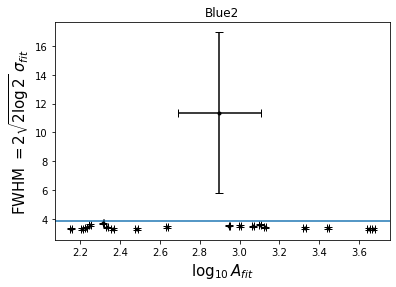

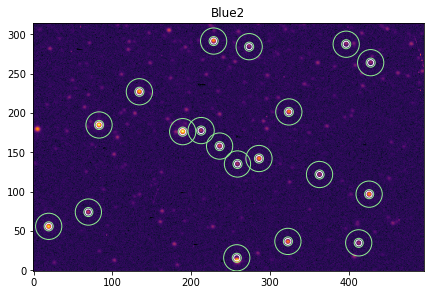

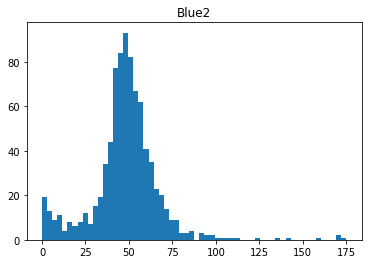

[0.57244953 0.6399042  1.11074408 1.42521568 1.88268457 1.8980113  2.01043601 1.51614073 2.17149359 2.29355534
 3.11003201 3.55862806 3.81337124 3.83795951 3.88182542 4.00723637 4.20589236 4.28640035 4.16820784]


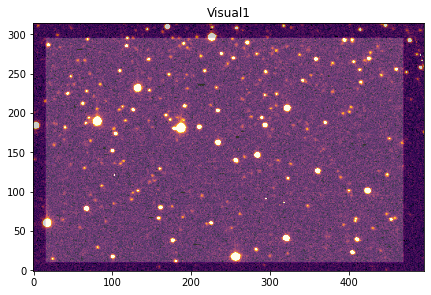

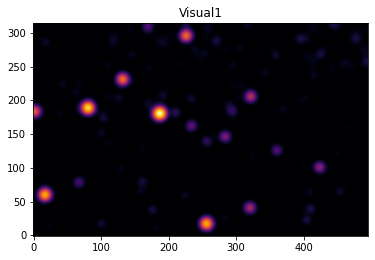

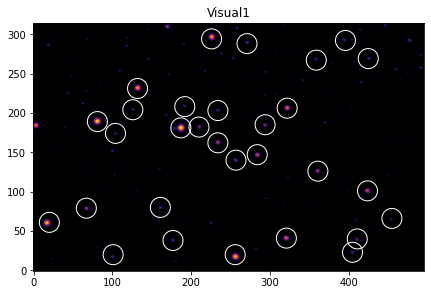

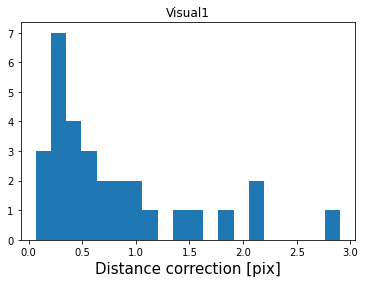

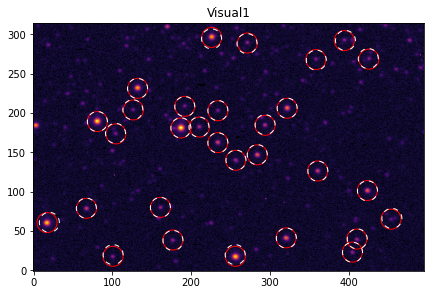

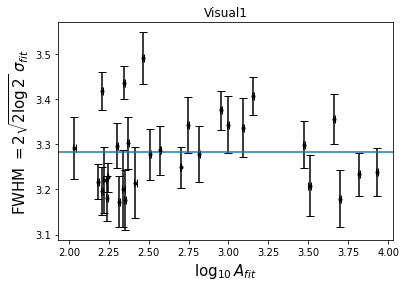

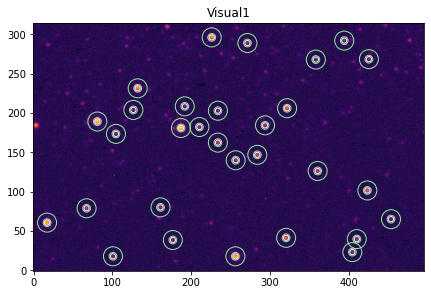

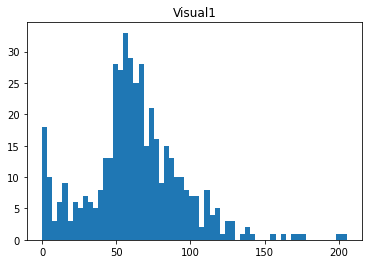

[-4.03631586 -3.75120074 -3.42817352 -3.43710268 -2.97740641 -2.92123681 -2.16720182 -1.99959539 -1.76254529
 -1.65821418 -1.28242235 -1.13367907 -0.96277339 -0.66455725 -0.49960621 -0.49334024 -0.25811695  0.01354834
  0.13184294 -0.16850879 -0.08067643 -0.16041596 -0.05307874  0.19285417  0.29546053  0.22729697  0.0112071
  0.19347763  0.60570253  0.34594914]


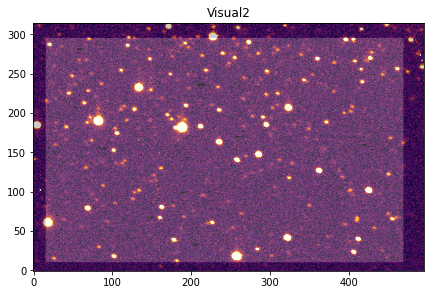

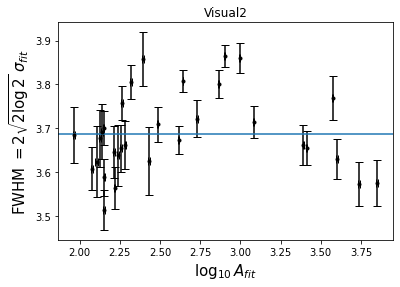

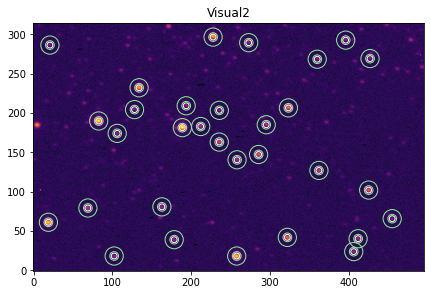

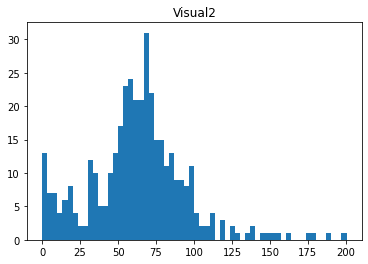

[-3.04127494 -2.7530984  -2.44160904 -2.43742956 -1.98317841 -1.93030528 -1.17284756 -1.01470022 -0.77460095
 -0.6662008  -0.30574628 -0.1047143   0.00810924  0.32795986  0.47066303  0.47703931  0.7004869   1.10803744
  0.89150892  1.02129162  0.85088568  0.83892193  0.95039377  1.16693488  1.02770385  1.16723644  1.22536486
  1.28833976  1.38560975  1.21999627  1.5423705 ]


In [12]:
for i in range(len(images)):
    img=images[i]
    X,Y = np.mgrid[:img.shape[0],:img.shape[1]]
    mask = (X>15) & (X<470) & (Y>10) & (Y<295)


    plt.figure(figsize=(7,7))
    quantile_imshow(img.T)#,vmin=300,vmax=600)
    plt.imshow(mask.T,alpha=0.2)
    plt.title(titles[i])
    plt.show()
    plt.imshow(ndi.gaussian_filter(img,5).T,vmin=50,norm="log")
    plt.title(titles[i])
    plt.show()


    peaks = peak_local_max(
        ndi.gaussian_filter(img,5),
        threshold_abs=60,
        labels=mask*1,
        min_distance=7,
        exclude_border=20)
    

    plt.figure(figsize=(7,7))
    plt.imshow(img.T,vmin=70,norm="log")    
    plt.scatter(*peaks.T,fc="none",ec="w",s=400)
    plt.title(titles[i])
    plt.show()

    centroids = np.array(
    centroid_sources((img-img.mean()).T,*peaks.T,centroid_func=centroid_quadratic,box_size=9)).T
    distances = np.hypot(*(peaks-centroids).T)
    plt.hist(distances,bins=20);
    plt.xlabel("Distance correction [pix]")
    plt.title(titles[i])
    plt.show()

    plt.figure(figsize=(7,7))
    plt.imshow(img.T,vmin=30,norm="log")
    plt.scatter(*centroids.T,fc="none",ec="r",s=400)
    plt.scatter(*peaks.T,fc="none",ec="w",s=400,linestyle=(5,(5,5)))
    plt.title(titles[i])
    plt.show()

    model = Const1D(100) + Gaussian1D(5e3,0,1.5)
    model.mean_1.fixed = True
    radii = np.arange(0,10,1)
    profile = RadialProfile(img.T,centroids[0],radii)
    fitted_model = fitter(model,profile.radius,profile.profile)

    params = []
    params_std = []
    for c in centroids:
        try:
            profile = RadialProfile(img.T,c,radii)
            fitted_model = fitter(model,profile.radius,profile.profile)
            params_std.append(np.sqrt(np.diag(fitter.fit_info["param_cov"])))
            params.append(fitted_model.parameters)
        except ValueError:
            pass
    #plt.plot(profile.radius,profile.gaussian_profile)
    #plt.plot(profile.radius,profile.profile,". k")
    #plt.show()
    #plt.close()

    params = np.asarray(params)
    params_std = np.asarray(params_std)


    x = np.log10(params.T[1])
    y = 2*np.sqrt(2*np.log(2))*params.T[3]
    dx = params_std.T[1]/params.T[1] / np.log(10)
    dy = 2*np.sqrt(2*np.log(2))*params_std.T[2]
    samples = np.random.normal(loc=y,scale=dy,size=(10_000,len(y)))
    means = samples.mean(axis=1)
    FWHM = means.mean()
    FWHM_err = means.std()

    plt.errorbar(x,y,dy,dx,fmt=". k",capsize=4)
    plt.xlabel("$\\log_{10} A_{fit}$")
    plt.ylabel("FWHM $= 2\\sqrt{2\\log 2}\\;\\sigma_{fit}$")
    plt.axhline(FWHM)
    plt.title(f"FWHM mean = ${FWHM:.3f}\\pm{FWHM_err:.3f}$")
    plt.title(titles[i])
    plt.show()

    min_distance=NearestNeighbors(n_neighbors=2).fit(centroids).kneighbors(centroids)[0][:,1].min()
    sky_apertures=CircularAnnulus(centroids,1.5*FWHM,0.85*(min_distance-FWHM))
    star_apertures=CircularAperture(centroids,FWHM)
    plt.figure(figsize=(7,7))
    plt.imshow(img.T,vmin=20,norm="log")
    sky_apertures.plot(color="lightgreen")
    star_apertures.plot(color="w")
    plt.title(titles[i])
    plt.show()

    sky_values=ApertureStats(img.T,sky_apertures).median
    star_values=ApertureStats(img.T,star_apertures).sum/star_apertures.area

    sky=sky_apertures[0].to_mask().get_values(img.T)
    plt.hist(sky,60)
    plt.title(titles[i])
    plt.show()

    mag_instr=-2.5*np.log10((star_values-sky_values)/headers[i]["EXPTIME"])
    

    Z=headers[i]["ZD"]
    Z1=float(Z[0:2])
    Z2=float(Z[3:5])/60
    Z3=float(Z[6:11])/(60*60)
    Z_def=Z1+Z2+Z3
    Z_def=(Z_def*180/np.pi)
    X1=1/(np.cos(Z_def)+(0.025*np.exp(-11*np.cos(Z_def))))
    X2=1/(np.cos(Z_def))
    if i <=1:
        k=0.4
    else:
        k=0.2
    mag1=mag_instr+(k*X1)
    mag2=mag_instr+(k*X2)
    dif_mag=mag1-mag2
    print(mag1)
    


In [13]:
glob("*")

['aperture_photometry_1.ipynb',
 'datos',
 'Fotometria General.ipynb',
 'Fotometria.ipynb',
 'Imagenes Reducidos']

In [14]:
dat = glob("datos\*.FITS")
dat

['datos\\Alcyone.fits', 'datos\\M92.fits', 'datos\\sextans_A.fits']

In [15]:
M92={x.name:x.data.astype(float) for x in fits.open("datos\M92.fits")}
#headers = [fits.getheader(f) for f in M92]
headers = {hdu.name: hdu.header for hdu in fits.open("datos\M92.fits")}
keys_M92 = list(M92.keys())

In [16]:
images=M92

In [17]:
def bias_model(x,y,/,m=0,b=1000,A=300,c=100,n=1):
    return m*x + b + n*x**2 + A*np.exp(-y/c)
BiasModel = custom_model(bias_model)
bias_model = BiasModel()

bias = images["BIAS 25"]
X,Y = np.mgrid[:bias.shape[0],:bias.shape[1]]
bias_model = fitter(bias_model,X,Y,bias)(X,Y)

flat = images["FLAT V 5"]
flat -= bias_model
flat /= flat.mean()

nombres={0:"B 1",1:"B 2", 2:"V 1", 3:"V 2"}

In [18]:
from photutils.utils import calc_total_error

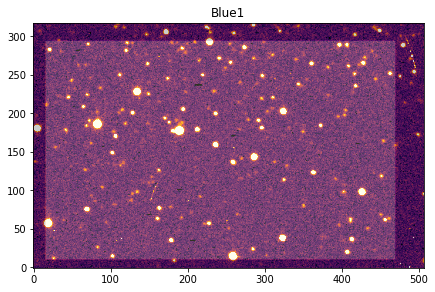

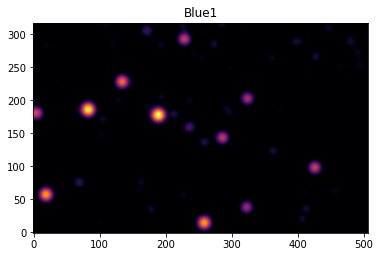

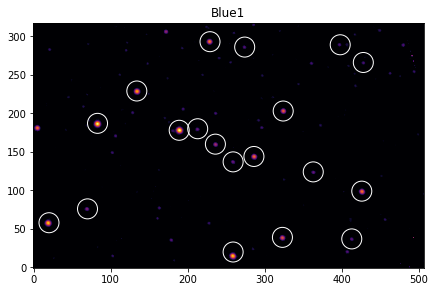

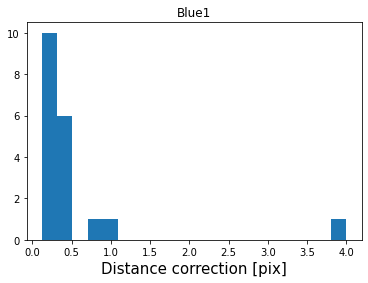

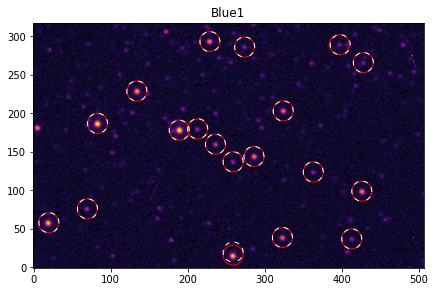

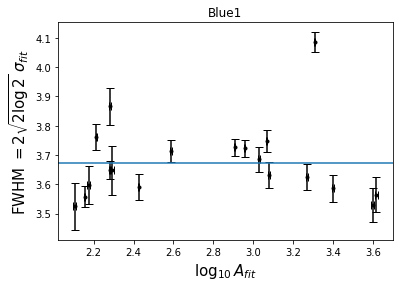

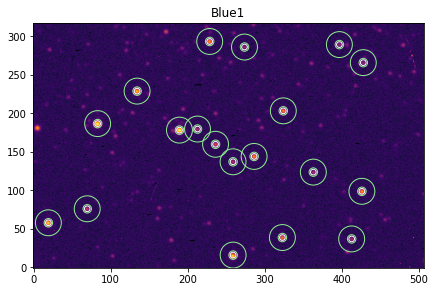

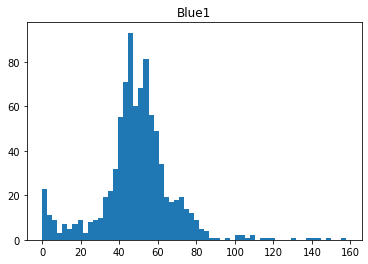

[-2.28641998 -2.21783899 -1.74692901 -1.4307805  -1.71714934 -0.97536505 -0.95228317 -0.85859336 -0.69199361
 -0.56651845  0.24884791  0.69413258  0.93757197  0.99073867  1.03495614  1.32960346  1.40637316  1.16289695
  1.2874437 ]


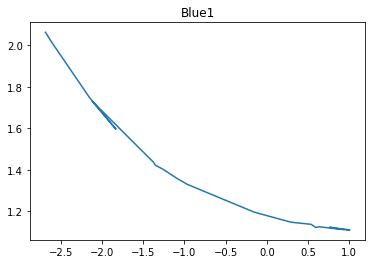

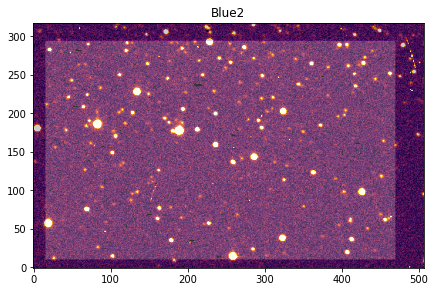

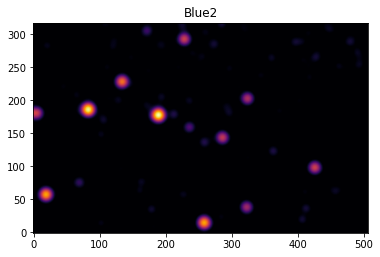

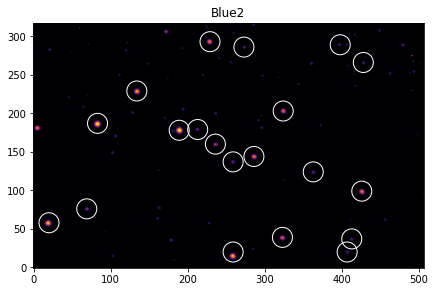

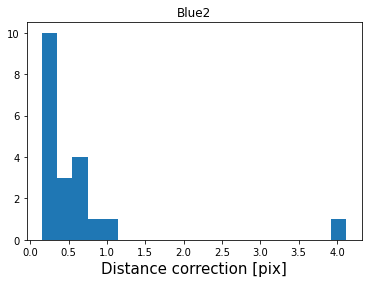

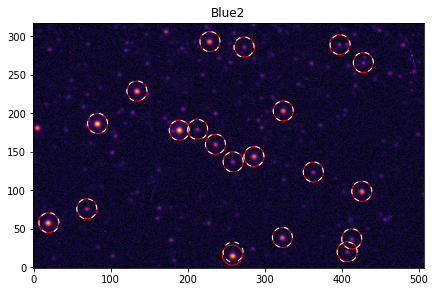

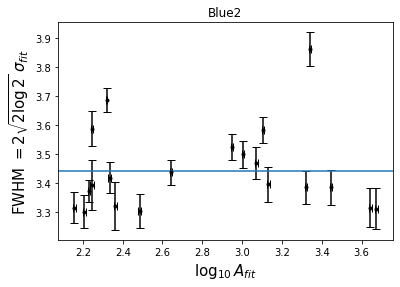

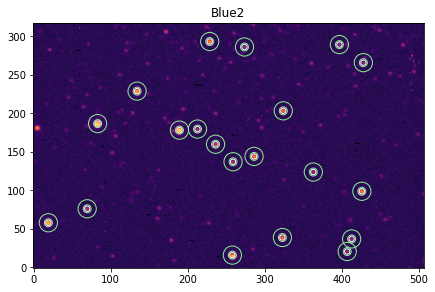

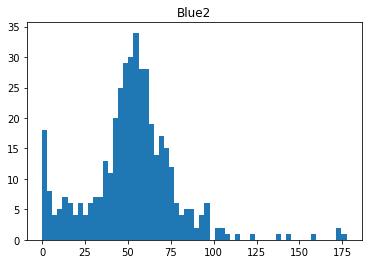

[0.38076389 0.45545489 0.9225807  1.2403369  0.98430339 1.69783808 1.7080206  1.82275326 1.9829136  2.11191652
 2.91938416 3.36706626 3.61843437 3.64610349 3.68918049 3.83336463 3.97728735 4.04618313 4.12445782 3.91349543]


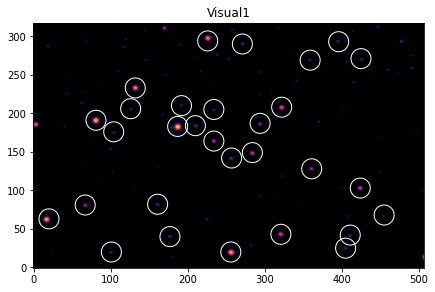

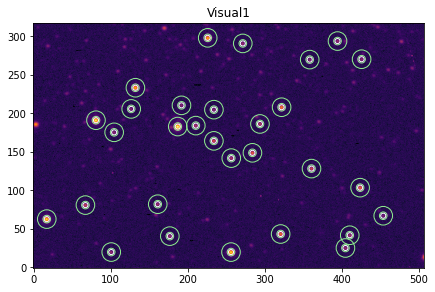

[-4.03490136 -3.74982277 -3.42728579 -3.43557226 -2.97542382 -2.91134702 -2.16591359 -1.99777906 -1.76075168
 -1.65567172 -1.2804233  -1.1311693  -0.96304246 -0.66445148 -0.49736881 -0.49106495 -0.25997918  0.01635062
  0.12885626 -0.16876339 -0.08081087 -0.15664333 -0.05350921  0.19395861  0.0062199   0.2949152   0.2251996
  0.19468813  0.60920517  0.33499578]


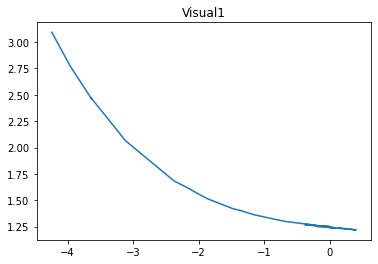

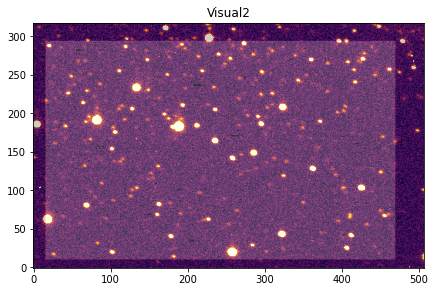

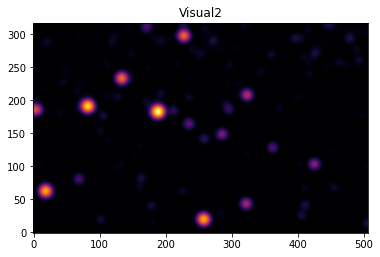

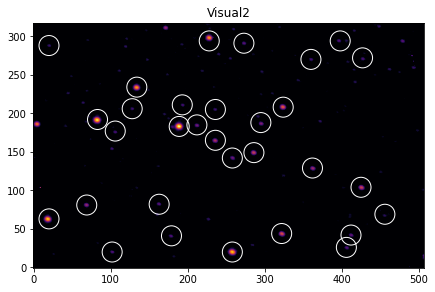

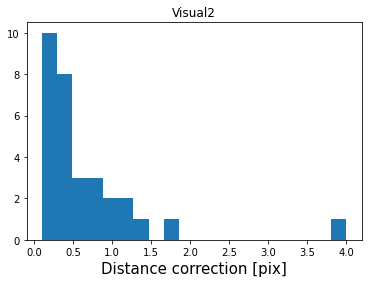

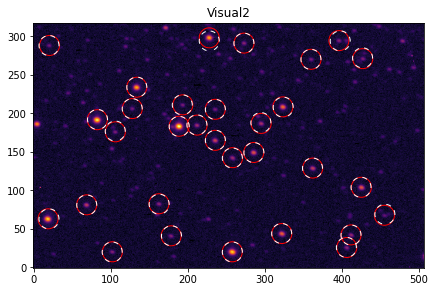

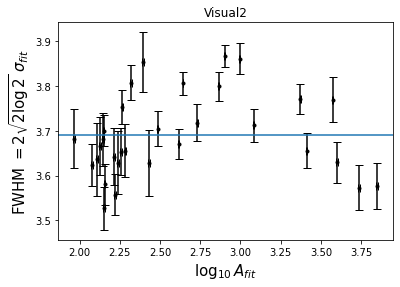

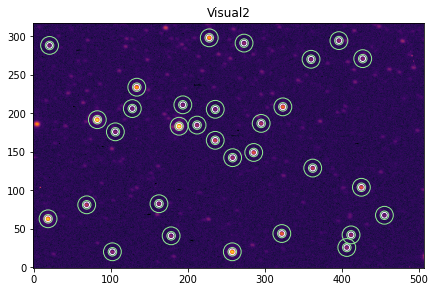

[-3.04038628 -2.75269236 -2.43688179 -2.44078964 -1.98239582 -1.92657323 -1.1720511  -1.01549894 -0.77428408
 -0.66449635 -0.30200363 -0.10404976  0.00890441  0.33045936  0.47521385  0.47502315  0.70304711  1.1087775
  0.89241864  1.02870522  0.85975533  0.84774542  0.95419055  1.16157064  1.03575471  1.16909225  1.22720727
  1.28185335  1.38079121  1.22391881  1.53506205]


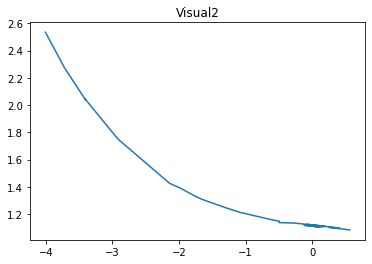

In [19]:
for i in range(len(nombres)):
    img=images[nombres[i]]- bias_model
    img /= flat
    X,Y = np.mgrid[:img.shape[0],:img.shape[1]]
    mask = (X>15) & (X<470) & (Y>10) & (Y<295)

    plt.figure(figsize=(7,7))
    quantile_imshow(img.T)#,vmin=300,vmax=600)
    plt.imshow(mask.T,alpha=0.2)
    plt.title(titles[i])
    plt.show()
    plt.imshow(ndi.gaussian_filter(img,5).T,vmin=50,norm="log")
    plt.title(titles[i])
    plt.show()


    peaks = peak_local_max(
        ndi.gaussian_filter(img,5),
        threshold_abs=60,
        labels=mask*1,
        min_distance=7,
        exclude_border=20)
    

    plt.figure(figsize=(7,7))
    plt.imshow(img.T,vmin=70,norm="log")    
    plt.scatter(*peaks.T,fc="none",ec="w",s=400)
    plt.title(titles[i])
    plt.show()

    centroids = np.array(
    centroid_sources((img-img.mean()).T,*peaks.T,centroid_func=centroid_quadratic,box_size=9)).T
    distances = np.hypot(*(peaks-centroids).T)
    plt.hist(distances,bins=20);
    plt.xlabel("Distance correction [pix]")
    plt.title(titles[i])
    plt.show()

    plt.figure(figsize=(7,7))
    plt.imshow(img.T,vmin=30,norm="log")
    plt.scatter(*centroids.T,fc="none",ec="r",s=400)
    plt.scatter(*peaks.T,fc="none",ec="w",s=400,linestyle=(5,(5,5)))
    plt.title(titles[i])
    plt.show()

    model = Const1D(100) + Gaussian1D(5e3,0,1.5)
    model.mean_1.fixed = True
    radii = np.arange(0,10,1)
    profile = RadialProfile(img.T,centroids[0],radii)
    fitted_model = fitter(model,profile.radius,profile.profile)

    params = []
    params_std = []
    for c in centroids:
        try:
            profile = RadialProfile(img.T,c,radii)
            fitted_model = fitter(model,profile.radius,profile.profile)
            params_std.append(np.sqrt(np.diag(fitter.fit_info["param_cov"])))
            params.append(fitted_model.parameters)
        except ValueError:
            pass
    #plt.plot(profile.radius,profile.gaussian_profile)
    #plt.plot(profile.radius,profile.profile,". k")
    #plt.show()
    #plt.close()

    params = np.asarray(params)
    params_std = np.asarray(params_std)


    x = np.log10(params.T[1])
    y = 2*np.sqrt(2*np.log(2))*params.T[3]
    dx = params_std.T[1]/params.T[1] / np.log(10)
    dy = 2*np.sqrt(2*np.log(2))*params_std.T[2]
    samples = np.random.normal(loc=y,scale=dy,size=(10_000,len(y)))
    means = samples.mean(axis=1)
    FWHM = means.mean()
    FWHM_err = means.std()

    plt.errorbar(x,y,dy,dx,fmt=". k",capsize=4)
    plt.xlabel("$\\log_{10} A_{fit}$")
    plt.ylabel("FWHM $= 2\\sqrt{2\\log 2}\\;\\sigma_{fit}$")
    plt.axhline(FWHM)
    plt.title(f"FWHM mean = ${FWHM:.3f}\\pm{FWHM_err:.3f}$")
    plt.title(titles[i])
    plt.show()

    min_distance=NearestNeighbors(n_neighbors=2).fit(centroids).kneighbors(centroids)[0][:,1].min()
    sky_apertures=CircularAnnulus(centroids,1.5*FWHM,0.85*(min_distance-FWHM))
    star_apertures=CircularAperture(centroids,FWHM)
    plt.figure(figsize=(7,7))
    plt.imshow(img.T,vmin=20,norm="log")
    sky_apertures.plot(color="lightgreen")
    star_apertures.plot(color="w")
    plt.title(titles[i])
    plt.show()

    sky_values=ApertureStats(img.T,sky_apertures).median
    star_values=ApertureStats(img.T,star_apertures).sum/star_apertures.area

    sky=sky_apertures[0].to_mask().get_values(img.T)
    plt.hist(sky,60)
    plt.title(titles[i])
    plt.show()

    mag_instr=-2.5*np.log10((star_values-sky_values)/headers[nombres[i]]["EXPTIME"])
    

    Z=headers[nombres[i]]["ZD"]
    Z1=float(Z[0:2])
    Z2=float(Z[3:5])/60
    Z3=float(Z[6:11])/(60*60)
    Z_def=Z1+Z2+Z3
    Z_def=(Z_def*180/np.pi)
    X1=1/(np.cos(Z_def)+(0.025*np.exp(-11*np.cos(Z_def))))
    X2=1/(np.cos(Z_def))
    if i <=1:
        k=0.4
    else:
        k=0.2
    mag1=mag_instr+(k*X1)
    mag2=mag_instr+(k*X2)
    dif_mag=mag1-mag2
    print(mag1)
    background=np.sqrt(25)*np.std(bias-bias_model)
    background_image=np.ones_like(bias)*background
    imag_err=calc_total_error(img,background_image,10.5)
    star_errors = [np.linalg.norm( s.to_mask().get_values(imag_err.T)/ star_apertures.area ) for s in star_apertures]
    plt.plot(mag_instr,star_errors)
    plt.title(titles[i])
    plt.show()
